# July 19,21, 2022: Compute Intersubject Functional Correlation (ISFC) values for `early` and `late` periods in `threat` and `safe` conditions

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import pickle, random
from tqdm import tqdm
from scipy.stats import (norm, zscore, permutation_test)
from itertools import combinations

# ISC
from brainiak.isc import (
    isc, isfc, bootstrap_isc, compute_summary_statistic, squareform_isfc, compute_correlation,
    _check_timeseries_input, _check_targets_input, _threshold_nans
)
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import squareform

# plotting
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr #CITE ITS PAPER IN YOUR MANUSCRIPT

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_dynamics')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/jul22"

# folders
sys.path.insert(0, proj_dir)
# import helpers.dataset_utils as dataset_utils

In [2]:
''''
exploratory data
'''
class ARGS(): pass
args = ARGS()

args.SEED = 74
args.LABELS = [0, 1]
args.NAMES = ['safe', 'threat']
args.MASK = -100

args.provide_roi_idxs = True
if args.provide_roi_idxs:
    with open(f"{proj_dir}/data/max/exploratory_data_roi_indices.pkl", 'rb') as f:
        args.up_roi_idxs, args.down_roi_idxs, args.roi_idxs = pickle.load(f)
        args.num_rois = len(args.roi_idxs)
else:
    args.num_rois = 85
    args.roi_idxs = np.arange(args.num_rois)

with open(f"{proj_dir}/data/max/exploratory_data_trial_level_responses.pkl", 'rb') as f:
    X = pickle.load(f)

'''
change roi ordering
'''
for label in args.LABELS:
    for idx_subj in range(len(X[label])):
        X[label][idx_subj] = X[label][idx_subj][:, :, args.roi_idxs]

In [3]:
args.up_roi_idxs, args.down_roi_idxs

(array([ 6,  7, 12, 13, 14, 15, 16, 17, 18, 19, 47, 48, 49, 50, 53, 54, 69,
        70, 73, 74, 75, 76, 77, 78, 79, 80]),
 array([ 0,  1,  2,  3,  4,  5, 20, 21, 22, 23, 24, 59, 60, 61, 62, 83, 84]))

In [4]:
'''
plotting tick labels
'''
minor_ticks = np.array([
    # 0, 
    len(args.up_roi_idxs),
    # len(args.up_roi_idxs) + len(args.down_roi_idxs)
])
print(minor_ticks)

# minor_tick_labels = np.array([
#     r'$\rightarrow$',
#     r'$\leftarrow$'+ r'$\rightarrow$',
#     r'$\leftarrow$',
# ])
# print(minor_tick_labels)

major_ticks = np.array([
    round(len(args.up_roi_idxs) // 2),
    round(len(args.up_roi_idxs) + len(args.down_roi_idxs) // 2),
])
print(major_ticks)

major_tick_labels = np.array([
    'up',
    'down',
])
print(major_tick_labels)

[26]
[13 34]
['up' 'down']


### `early` and `late` periods 

In [5]:
# step 1. sort trials based on number of nan values present
for label in args.LABELS:
    for idx in np.arange(len(X[label])):
        x = X[label][idx]
        num_nans_trial = np.squeeze(
            np.apply_over_axes(
                np.sum, 
                np.isnan(x), 
                axes=(1, 2)
            )
        )
        num_nans_trial_idxs = np.argsort(num_nans_trial)
        x = x[num_nans_trial_idxs, :, :]
        X[label][idx] = x

# step 2. create time series
'''
find minimum number of trials across subjects
'''
min_trials = []
for label in args.LABELS:
    min_trials += [x.shape[0] for x in X[label]]
min_trials = min(min_trials)
print(f"minimum number of trials = {min_trials}")

'''
time series of early and late periods
'''
args.PERIODS = ['early', 'late']
# time periods
args.TR = 1.25 #seconds
EARLY = np.arange(2.5, 8.75+args.TR, args.TR) // args.TR
LATE = np.arange(10.0, 16.25+args.TR, args.TR) // args.TR
EARLY = EARLY.astype(int)
LATE = LATE.astype(int)
args.PERIOD_TRS = [EARLY, LATE]

ts = {}
for label, name in zip(args.LABELS, args.NAMES):
    for idx_period, (period, TRs) in enumerate(zip(args.PERIODS, args.PERIOD_TRS)):
        ts[f"{name}_{period}"] = []
        for x in X[label]:
            x = x[:, args.PERIOD_TRS[idx_period], :]
            trl, t, r = x.shape
            x = np.reshape(x[:min_trials, ...], (min_trials*t, r))
            ts[f"{name}_{period}"] += [zscore(x, axis=0, nan_policy='omit')]

for block in ts.keys():
    ts[block] = np.dstack(ts[block])

minimum number of trials = 11


### Intersubject correlations

**Following the pipeline in ISC tutorial**

Paper: https://academic.oup.com/scan/article/14/6/667/5489905
Tutorial: https://github.com/snastase/isc-tutorial

Statistical significance was assessed by a nonparametric bootstrap hypothesis test resampling left-out subjects (Leavo-one-out (LOO)). 
<!-- and corrected for multiple tests by controlling FDR at .05. -->

i.e.:
1. Compute leave-one-out (LOO) ISC and ISFC values
2. Bootstrap hypothesis testing, (Chen et al.2016: https://doi.org/10.1016/j.neuroimage.2016.05.023)
<!-- 3. Multiple tests correction: False Discovery Rate (FDR) at 0.05. -->

LOO method relates to computing ISFC values, as the mean time series of the remaining subjects converges to the common signal across subjects.

In [6]:
def get_isfcs(args, ts):
    corrs = {}; bootstraps = {}; rois = {}

    for block in ts.keys():
        # if block == 'safe_early': continue
        isfcs, iscs = isfc(
            ts[block], 
            pairwise=args.pairwise, 
            summary_statistic=None,
            vectorize_isfcs=args.vectorize_isfcs
        )
        corrs[block] = {'isfcs':isfcs, 'iscs':iscs}

        bootstraps[block] = {}
        rois[block] = {}
        for corr_name in args.CORR_NAMES:
            
            # permutation test
            observed, ci, p, distribution = bootstrap_isc(
                corrs[block][corr_name], 
                pairwise=args.pairwise, 
                summary_statistic='median',
                n_bootstraps=args.n_bootstraps,
                ci_percentile=95, 
                side='two-sided',
                random_state=args.SEED
            )
            bootstraps[block][corr_name] = observed, ci, p, distribution

            # surviving rois
            # rois[block][corr_name] = q[block][corr_name] < 0.05
            rois[block][corr_name] = bootstraps[block][corr_name][2] < 0.05 # p < 0.05

            # correlations only for surviving rois
            # corrs[block][corr_name] *= rois[block][corr_name]

            print(
                (
                    f"condition {block} and correlation {corr_name[:-1]} : " 
                    f"{100. * np.sum(rois[block][corr_name]) / len(rois[block][corr_name])} %"
                    f"significant roi(-pairs)"
                )
            )

    return corrs, bootstraps, rois

In [7]:
def get_min_max(d):
    '''
    min and max values of the matrices:
    used in plotting the matrices
    '''
    vals = []
    for block in d.keys():
        vals.append(d[block])
    vals = np.concatenate(vals, axis=0).flatten()
    vmin = np.nanquantile(vals, q=0.05)
    vmax = np.nanquantile(vals, q=0.95)
    return -max(-vmin, vmax), max(-vmin, vmax)

In [8]:
def plot_isfcs(args, isfcs, rois): 
    vmin, vmax = get_min_max(isfcs)

    nrows, ncols = len(args.LABELS), len(args.PERIODS)
    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols, 
        figsize=(5*ncols, 4*nrows), 
        sharex=False, 
        sharey=False, 
        dpi=120
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=None, hspace=0.5
    )

    for label, name in zip(args.LABELS, args.NAMES):
        for idx_period, period in enumerate(args.PERIODS):
            ax = axs[label, idx_period]
            block = f"{name}_{period}"

            # if block == 'safe_early': continue

            im = ax.imshow(
                isfcs[block], #* rois[block], 
                cmap=cmr.iceburn, vmin=vmin, vmax=vmax
            )
            ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

            if label == 0: ax.set_title(f"{period}")
            if idx_period == 0: ax.set_ylabel(f"{name}", size='large')
            
            ax.set_yticks(major_ticks, major_tick_labels, rotation=90, va='center')
            ax.set_xticks(major_ticks, major_tick_labels, rotation=0, ha='center')

            ax.set_yticks(minor_ticks-0.5, minor=True)
            ax.set_xticks(minor_ticks-0.5, minor=True)
            ax.tick_params(
                which='major', direction='out', length=7, 
                # grid_color='white', grid_linewidth='1.5'
            )
            ax.grid(which='minor', color='w', linestyle='-', linewidth=1.5)

    return None

In [9]:
'''
leave-one-out ISFC
bootstrap
'''
args.CORR_NAMES = ['isfcs', 'iscs']
args.pairwise = False
args.vectorize_isfcs = True
args.n_bootstraps = 1000

corrs, bootstraps, rois = get_isfcs(args, ts)

# # multiple tests correction
# q = {}; z = {};
# q[block][corr_name] = multipletests(bootstraps[block][corr_name][2], method='fdr_by')[1]
# z[block][corr_name] = np.abs(norm.ppf(q[block][corr_name]))

condition safe_early and correlation isfc : 51.605758582502766 %significant roi(-pairs)
condition safe_early and correlation isc : 55.81395348837209 %significant roi(-pairs)
condition safe_late and correlation isfc : 13.842746400885936 %significant roi(-pairs)
condition safe_late and correlation isc : 20.930232558139537 %significant roi(-pairs)
condition threat_early and correlation isfc : 34.44075304540421 %significant roi(-pairs)
condition threat_early and correlation isc : 39.53488372093023 %significant roi(-pairs)
condition threat_late and correlation isfc : 14.728682170542635 %significant roi(-pairs)
condition threat_late and correlation isc : 13.953488372093023 %significant roi(-pairs)


Showing ISFC values for each period only for the *significant* roi-pairs.

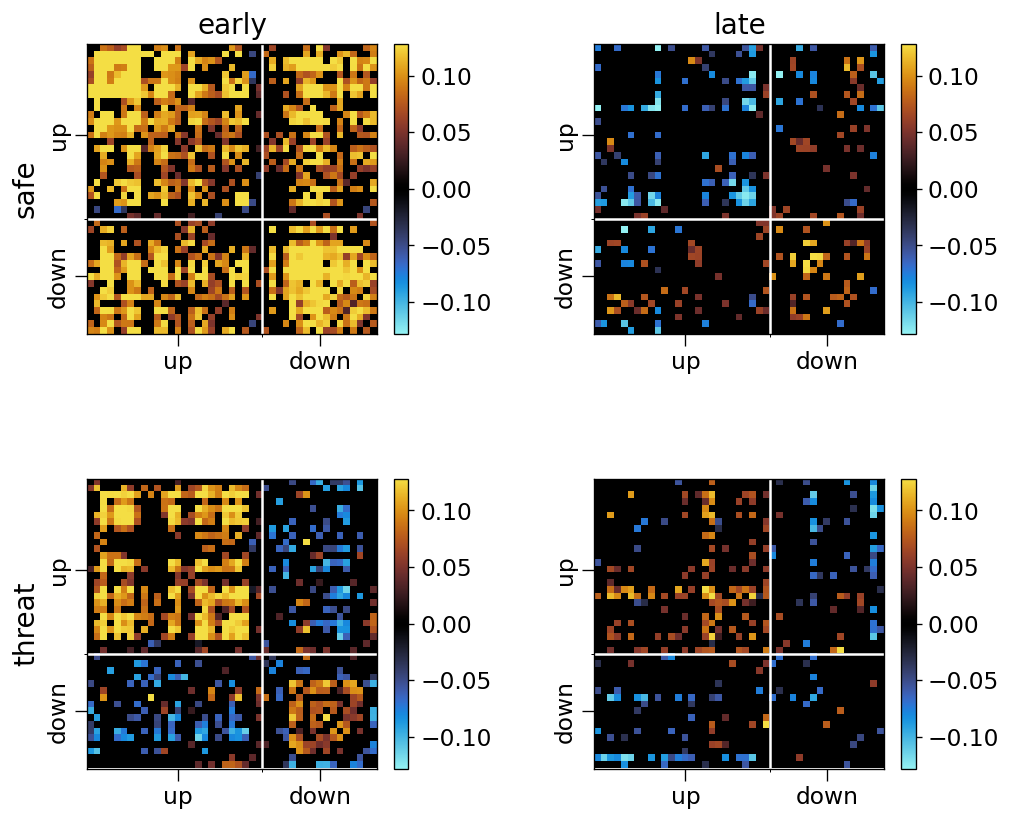

In [10]:
observed_isfcs = {}; observed_p_vals = {}; 
significant_rois = {}; conf_intervals = {}
for block in bootstraps.keys():
    # if block == 'safe_early': continue
    observed_isfcs[block] = squareform_isfc(
        bootstraps[block]['isfcs'][0], 
        bootstraps[block]['iscs'][0]
    )
    observed_p_vals[block] = squareform_isfc(
        bootstraps[block]['isfcs'][2], 
        bootstraps[block]['iscs'][2]
    )
    significant_rois[block] = squareform_isfc(
        rois[block]['isfcs'], 
        rois[block]['iscs']
    )
    conf_intervals[block] = (
        squareform_isfc(
            bootstraps[block]['isfcs'][1][0],
            bootstraps[block]['iscs'][1][0]
        ),
        squareform_isfc(
            bootstraps[block]['isfcs'][1][1],
            bootstraps[block]['iscs'][1][1]
        )
    )

    observed_isfcs[block] *= significant_rois[block]

plot_isfcs(args, observed_isfcs, significant_rois)

### statistical testing: pairwise non parametric permutation test

We perform a non parametric pairwise permutation test suggested by Chen et al.2016 (https://doi.org/10.1016/j.neuroimage.2016.05.023) to compare ISFC matrices between any two pairs of conditions. 

We use statistic in the permutation test as the difference between median ISFC matrices between two conditions.

We plot the statistic between every pair of conditions only for the roi-pairs that differentiate significantly between the conditions.

In [11]:
def get_comparison_stats(args, corrs,):
    def statistic(obs1, obs2, axis):
        return (
            + compute_summary_statistic(obs1, summary_statistic='median', axis=axis) 
            - compute_summary_statistic(obs2, summary_statistic='median', axis=axis)
        ) 

    stats_results = {}
    for (block1, block2) in tqdm(combinations(corrs.keys(), 2)):
        obs1 = np.concatenate([corrs[block1]['isfcs'], corrs[block1]['iscs']], axis=-1)
        obs2 = np.concatenate([corrs[block2]['isfcs'], corrs[block2]['iscs']], axis=-1)
        
        stats_results[(block1, block2)] = permutation_test(
            data=(obs1, obs2),
            statistic=statistic,
            permutation_type='samples',
            vectorized=True,
            n_resamples=args.n_bootstraps,
            batch=5,
            alternative='two-sided',
            axis=0,
            random_state=args.SEED
        )
    
    return stats_results

In [12]:
def plot_isfc_comparisons(args, corrs, diff_isfcs,):
    vmin, vmax = get_min_max(diff_isfcs)

    nrows, ncols = [len(corrs.keys())]*2
    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols, 
        figsize=(4*ncols, 4*nrows), 
        sharex=False, 
        sharey=False, 
        dpi=120
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=0.45, hspace=None
    )

    for idx_blk1, block1 in enumerate(corrs.keys()):
        for idx_blk2, block2 in enumerate(corrs.keys()):

            if idx_blk1 <= idx_blk2: 
                axs[idx_blk1, idx_blk2].remove()
                continue

            ax = axs[idx_blk1, idx_blk2]

            im = ax.imshow(
                diff_isfcs[(block2, block1)], 
                cmap=cmr.iceburn, vmin=vmin, vmax=vmax
            )
            ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

            if idx_blk1 == idx_blk2+1: ax.set_title(f"{block2}")
            if idx_blk2 == 0: ax.set_ylabel(f"{block1}", size='large')

            ax.set_yticks(major_ticks, major_tick_labels, rotation=90, va='center')
            ax.set_xticks(major_ticks, major_tick_labels, rotation=0, ha='center')

            ax.set_yticks(minor_ticks-0.5, minor=True)
            ax.set_xticks(minor_ticks-0.5, minor=True)
            ax.tick_params(
                which='major', direction='out', length=7, 
                # grid_color='white', grid_linewidth='1.5'
            )
            ax.grid(which='minor', color='w', linestyle='-', linewidth=1.5)

In [13]:
stats_results = get_comparison_stats(args, corrs)

diff_isfcs = {}; diff_pvals = {}
for (block1, block2) in stats_results.keys():
    diff_isfcs[(block1, block2)] = squareform_isfc(
        isfcs=stats_results[(block1, block2)].statistic[:-args.num_rois],
        iscs=stats_results[(block1, block2)].statistic[-args.num_rois:]
    )

    diff_pvals[(block1, block2)] = squareform_isfc(
        isfcs=stats_results[(block1, block2)].pvalue[:-args.num_rois],
        iscs=stats_results[(block1, block2)].pvalue[-args.num_rois:],
    )
    diff_pvals[(block1, block2)] = diff_pvals[(block1, block2)] < 0.05
    # FDR correction
    # coming soon...

    # keep isfc values only for significant roi pairs
    diff_isfcs[(block1, block2)] *= diff_pvals[(block1, block2)]
    diff_isfcs[(block1, block2)] *= significant_rois[block1]
    diff_isfcs[(block1, block2)] *= significant_rois[block2]


cond_idx = {}
for idx, block in enumerate(corrs.keys()):
    cond_idx[block] = idx

6it [00:12,  2.03s/it]


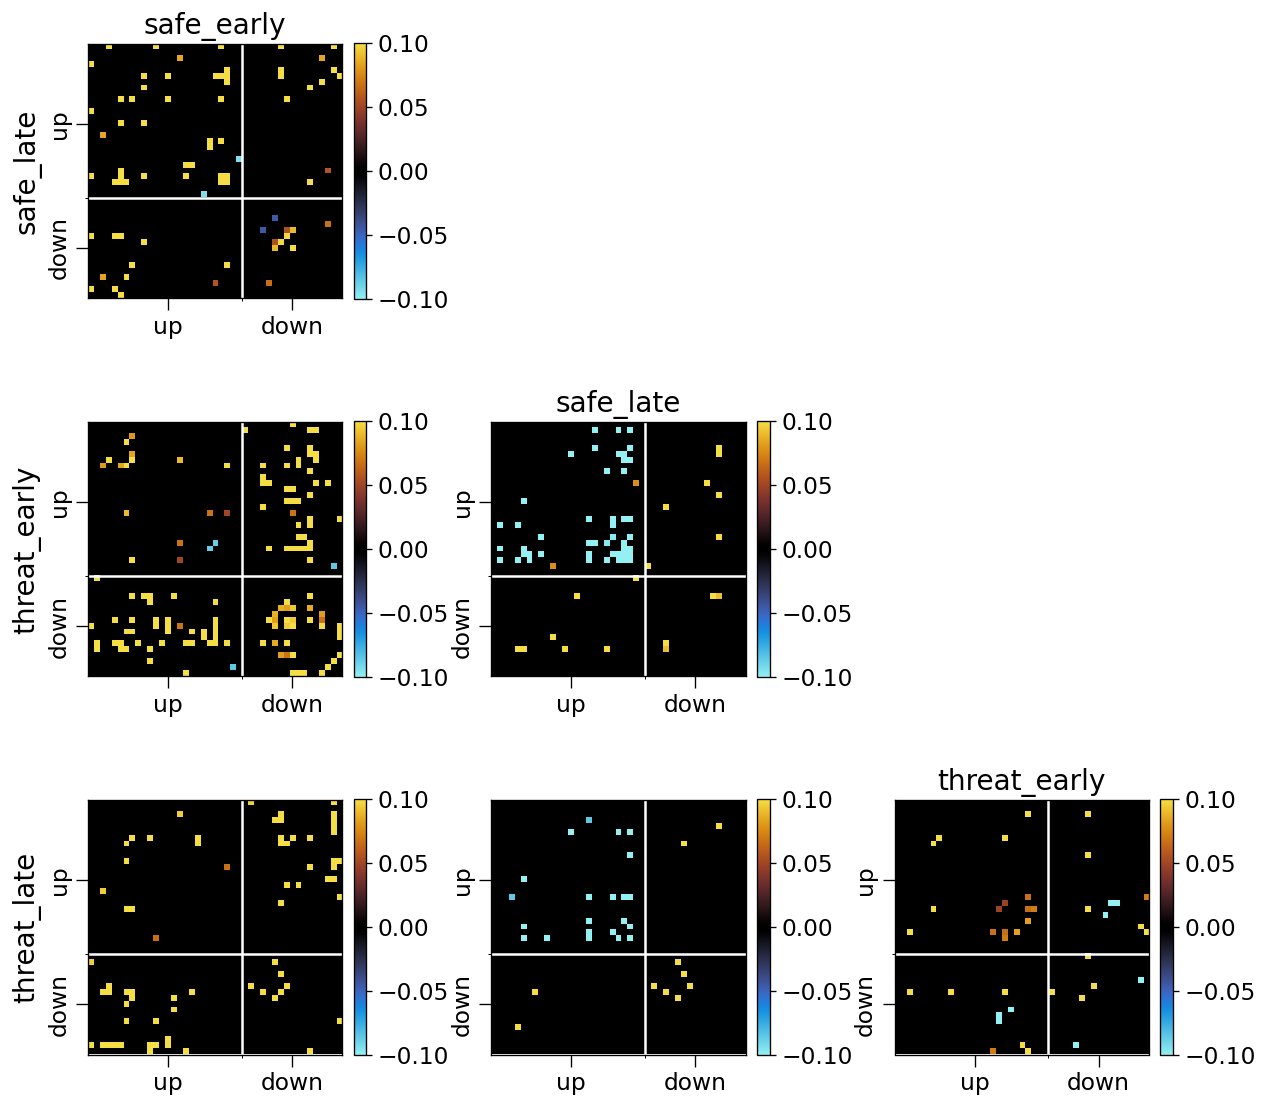

In [14]:
plot_isfc_comparisons(args, corrs, diff_isfcs)